# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [16]:
! git clone https://github.com/vcasadei/MNIST.git

fatal: destination path 'MNIST' already exists and is not an empty directory.


In [17]:
! ls MNIST

processed raw


In [18]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [19]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(np.float64(-0.5), np.float64(232.5), np.float64(87.5), np.float64(-0.5))

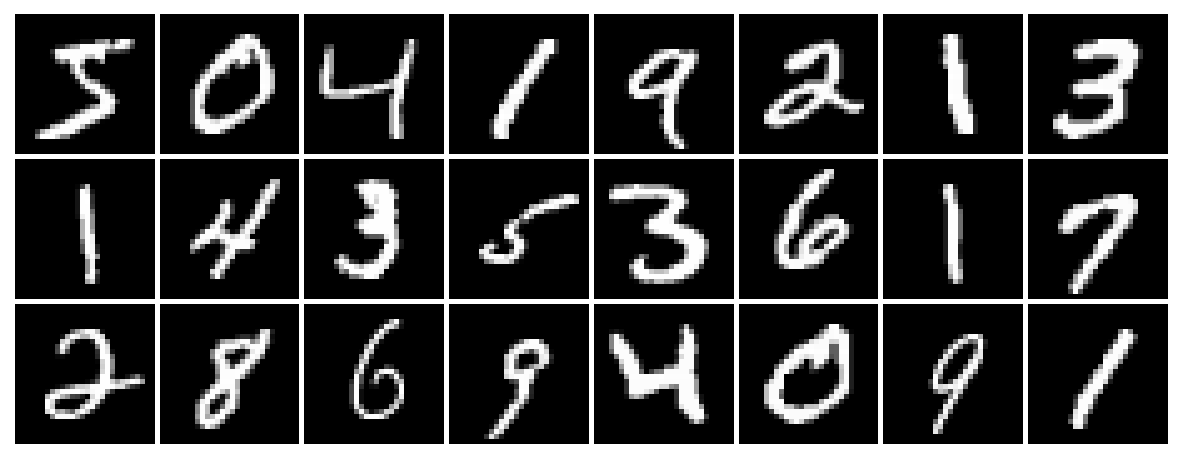

In [20]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


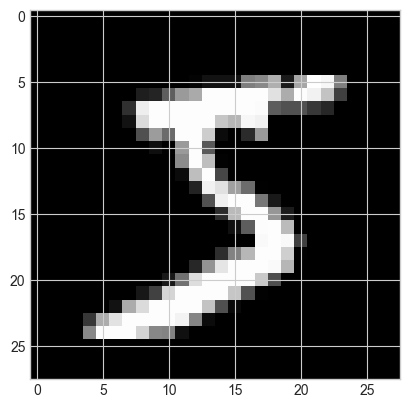

In [21]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [22]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [23]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[ 0.0412,  0.0357, -0.2008,  0.3361, -0.0470,  0.0945, -0.0237,  0.1858,
         -0.0374, -0.0192],
        [-0.2237,  0.3557,  0.1686,  0.1735,  0.1269,  0.0661, -0.0828, -0.0838,
         -0.2048, -0.1388],
        [-0.0240, -0.0031,  0.2743,  0.1982, -0.3648, -0.0795,  0.1020, -0.1542,
         -0.0781,  0.3697],
        [-0.0347,  0.0706, -0.0938, -0.0424, -0.0365,  0.1493,  0.0433, -0.0822,
         -0.0306, -0.2559],
        [-0.0577,  0.3908,  0.1812,  0.0031,  0.3022,  0.2358, -0.0044,  0.3059,
         -0.1155, -0.0636]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [24]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [25]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(2.2885, grad_fn=<NllLossBackward0>)

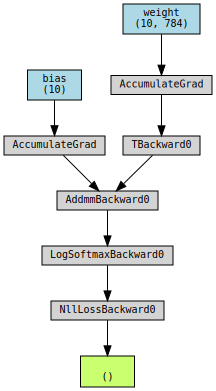

In [13]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [26]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()


In [27]:
print('Final loss:', loss.item())

Final loss: 0.26562678813934326


### Visualizando gráfico de perda durante o treinamento

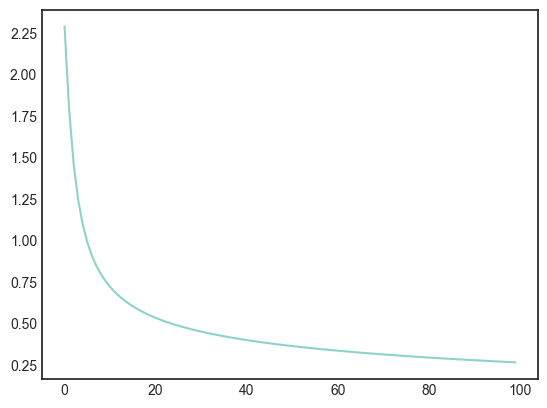

In [33]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [29]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.942


### Matriz de confusão com dados de treinamento e teste

In [30]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,110,1,0,0,0,2,2,1,0
2,0,1,91,1,0,1,0,1,2,1
3,0,0,0,88,0,2,0,0,0,0
4,0,0,1,0,102,2,1,2,0,3
5,0,2,0,1,0,82,0,0,2,1
6,1,0,1,1,2,2,90,0,0,0
7,0,1,1,1,0,0,0,111,0,3
8,0,2,2,0,0,1,0,0,82,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


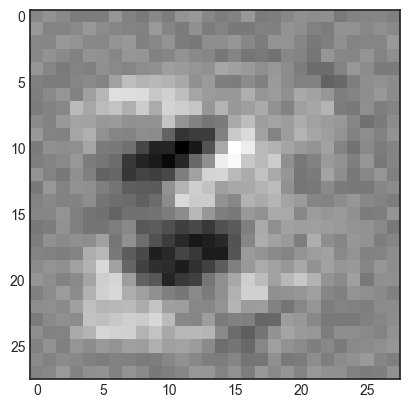

In [34]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

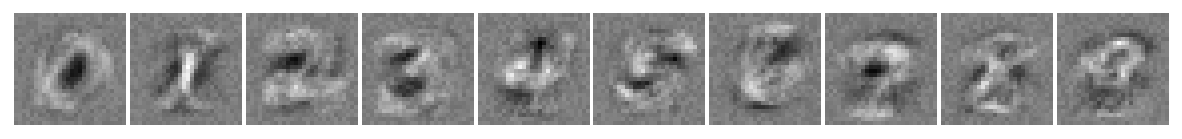

In [35]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

In [36]:
losses = []
zs = []

for i in range(epochs):
    inputs = Variable(x_train.view(-1, 28 * 28))

    outputs = model(inputs)

    zs.append(outputs[1].detach().numpy())

    loss = criterion(outputs, Variable(y_train))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    print(f"Epoch[{i+1}/{epochs}], Loss: {loss.item():.6f}, Acc: {accuracy:.6f}")

Epoch[1/100], Loss: 0.264295, Acc: 0.942000
Epoch[2/100], Loss: 0.262979, Acc: 0.942000
Epoch[3/100], Loss: 0.261678, Acc: 0.942000
Epoch[4/100], Loss: 0.260393, Acc: 0.942000
Epoch[5/100], Loss: 0.259122, Acc: 0.942000
Epoch[6/100], Loss: 0.257866, Acc: 0.942000
Epoch[7/100], Loss: 0.256624, Acc: 0.942000
Epoch[8/100], Loss: 0.255395, Acc: 0.943000
Epoch[9/100], Loss: 0.254181, Acc: 0.944000
Epoch[10/100], Loss: 0.252979, Acc: 0.944000
Epoch[11/100], Loss: 0.251791, Acc: 0.945000
Epoch[12/100], Loss: 0.250615, Acc: 0.945000
Epoch[13/100], Loss: 0.249452, Acc: 0.946000
Epoch[14/100], Loss: 0.248301, Acc: 0.946000
Epoch[15/100], Loss: 0.247162, Acc: 0.946000
Epoch[16/100], Loss: 0.246035, Acc: 0.946000
Epoch[17/100], Loss: 0.244919, Acc: 0.948000
Epoch[18/100], Loss: 0.243815, Acc: 0.948000
Epoch[19/100], Loss: 0.242722, Acc: 0.949000
Epoch[20/100], Loss: 0.241640, Acc: 0.949000
Epoch[21/100], Loss: 0.240568, Acc: 0.949000
Epoch[22/100], Loss: 0.239508, Acc: 0.950000
Epoch[23/100], Loss

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

Epoch[1/100], Loss: 0.074205, Acc: 0.998000


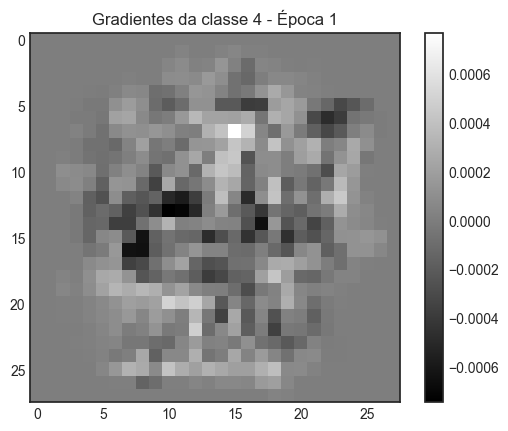

Epoch[2/100], Loss: 0.074090, Acc: 0.998000


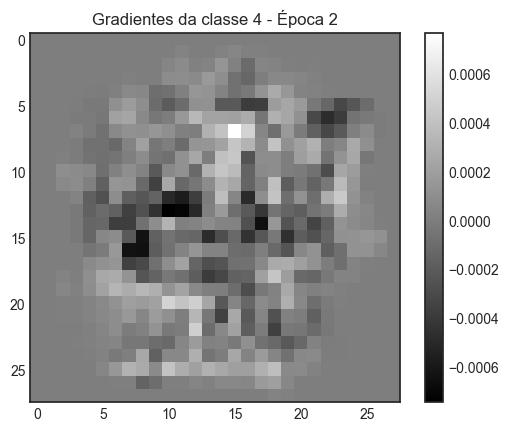

Epoch[3/100], Loss: 0.073975, Acc: 0.998000


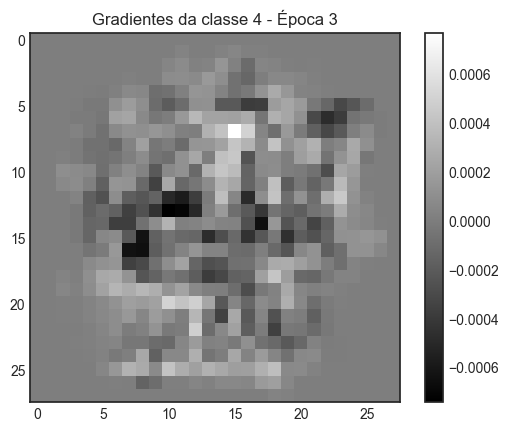

Epoch[4/100], Loss: 0.073860, Acc: 0.998000


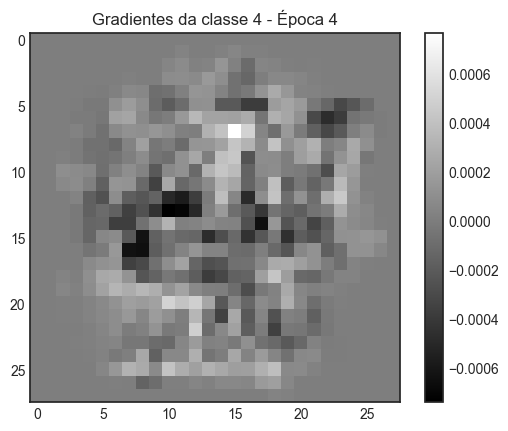

Epoch[5/100], Loss: 0.073746, Acc: 0.998000


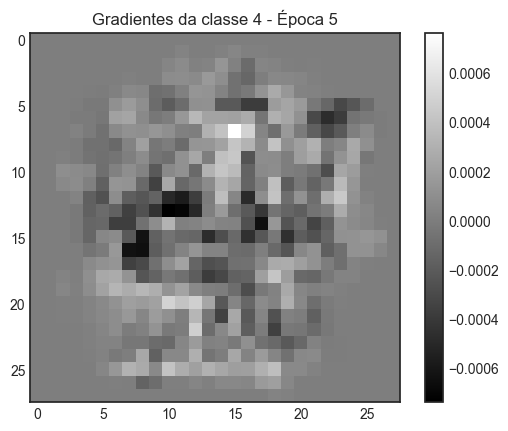

Epoch[6/100], Loss: 0.073632, Acc: 0.998000


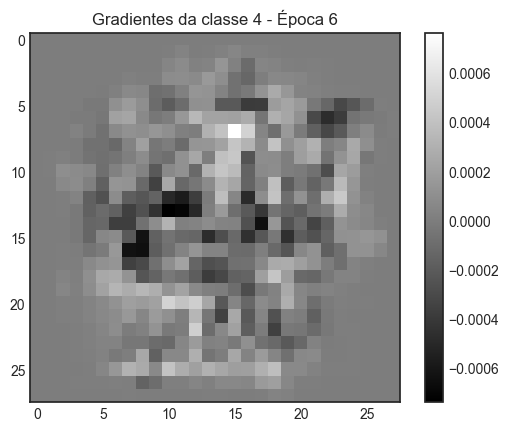

Epoch[7/100], Loss: 0.073519, Acc: 0.998000


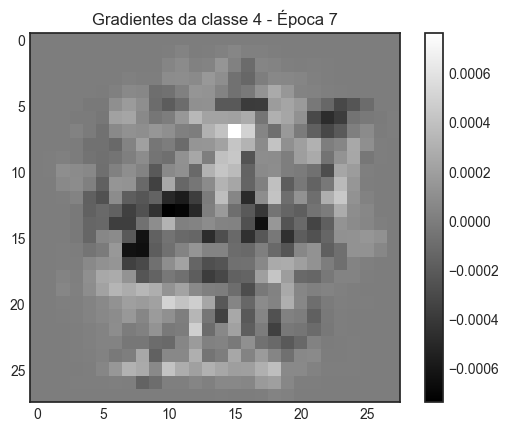

Epoch[8/100], Loss: 0.073406, Acc: 0.998000


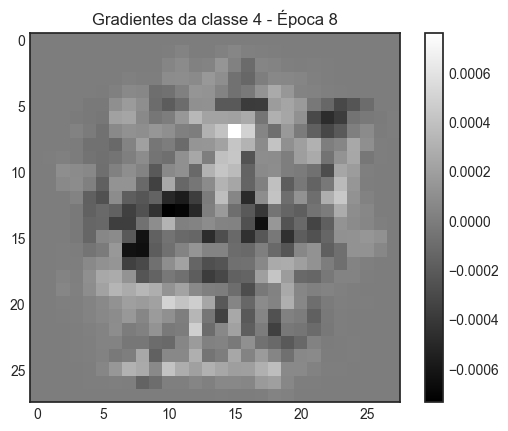

Epoch[9/100], Loss: 0.073293, Acc: 0.998000


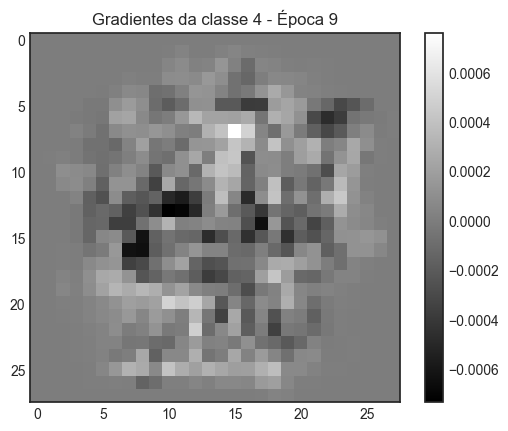

Epoch[10/100], Loss: 0.073181, Acc: 0.998000


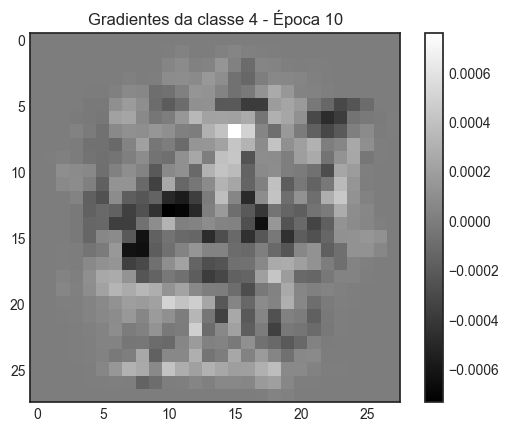

Epoch[11/100], Loss: 0.073068, Acc: 0.998000


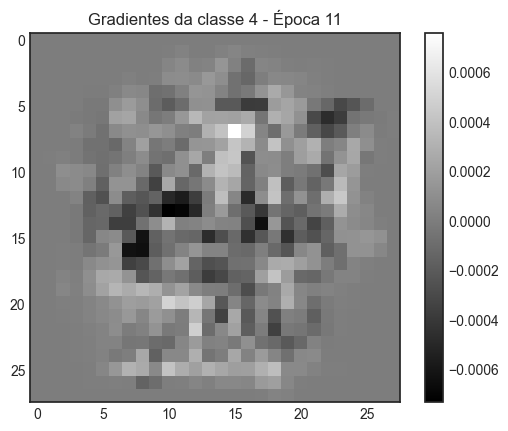

Epoch[12/100], Loss: 0.072957, Acc: 0.998000


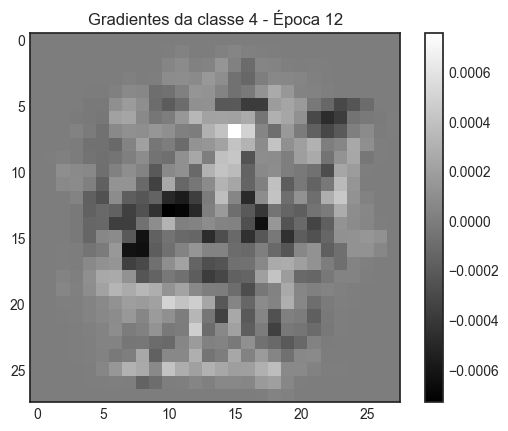

Epoch[13/100], Loss: 0.072845, Acc: 0.998000


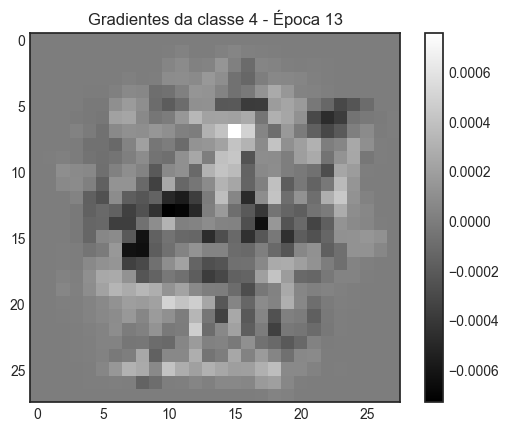

Epoch[14/100], Loss: 0.072734, Acc: 0.998000


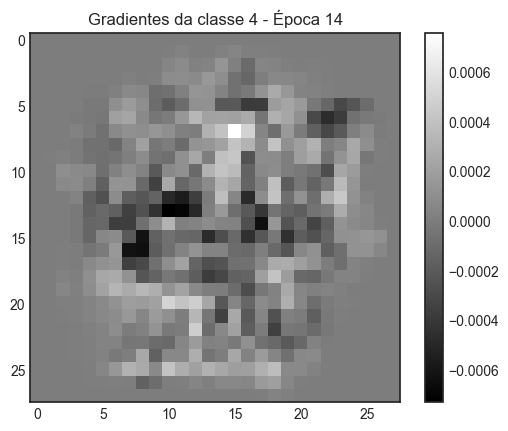

Epoch[15/100], Loss: 0.072623, Acc: 0.998000


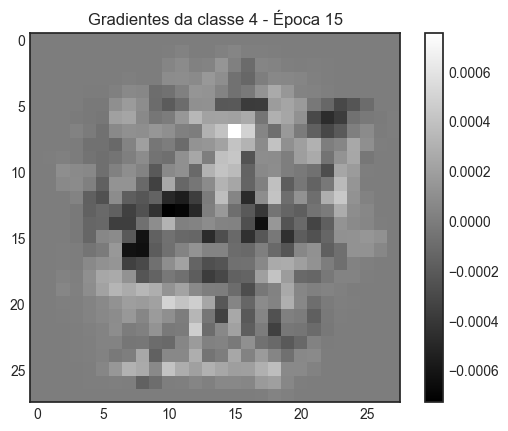

Epoch[16/100], Loss: 0.072513, Acc: 0.998000


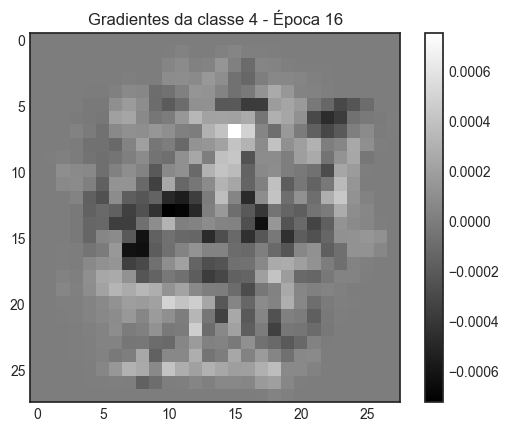

Epoch[17/100], Loss: 0.072402, Acc: 0.998000


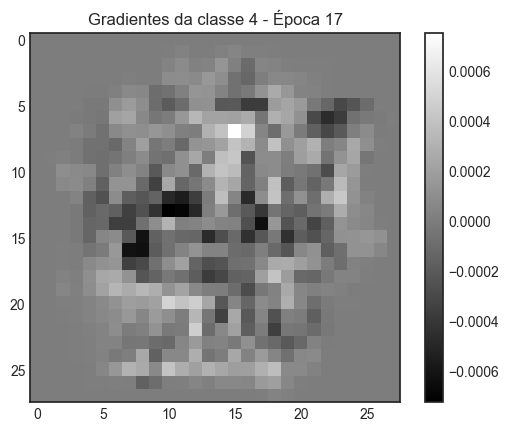

Epoch[18/100], Loss: 0.072293, Acc: 0.998000


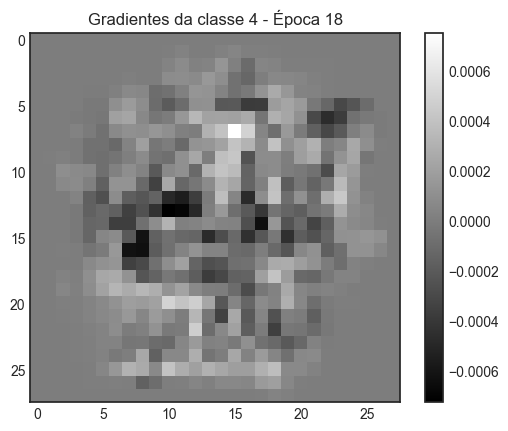

Epoch[19/100], Loss: 0.072183, Acc: 0.998000


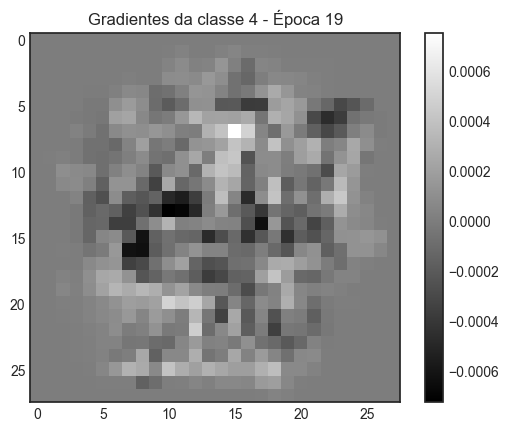

Epoch[20/100], Loss: 0.072074, Acc: 0.998000


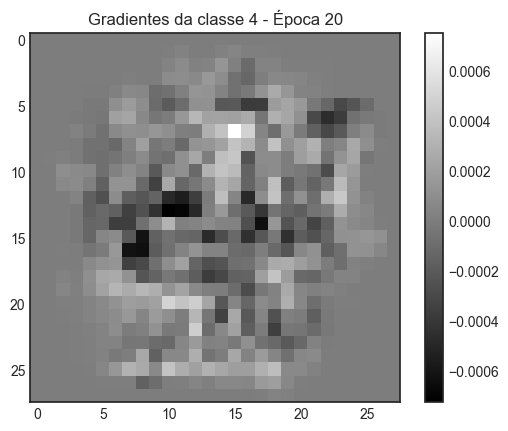

Epoch[21/100], Loss: 0.071965, Acc: 0.998000


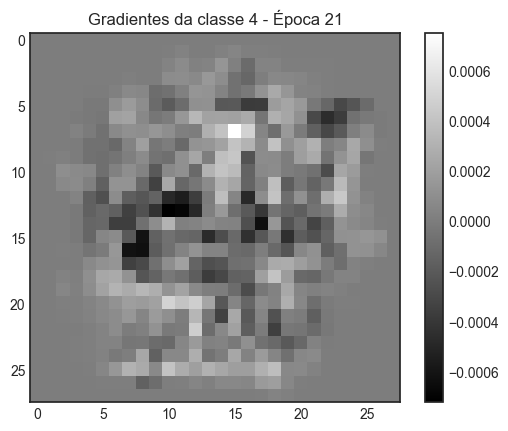

Epoch[22/100], Loss: 0.071856, Acc: 0.998000


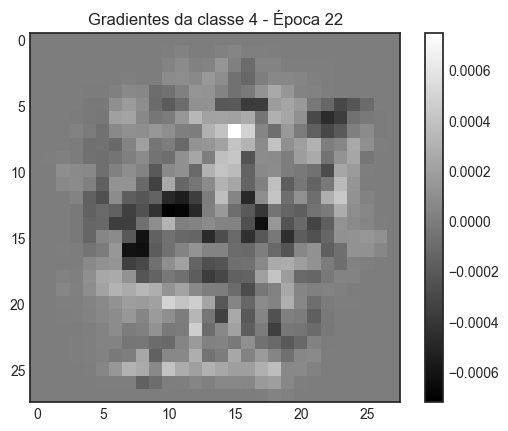

Epoch[23/100], Loss: 0.071748, Acc: 0.998000


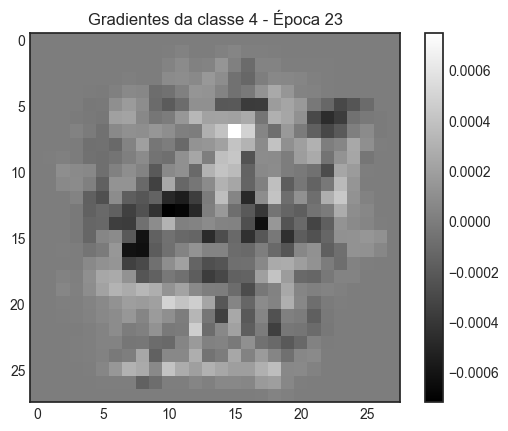

Epoch[24/100], Loss: 0.071640, Acc: 0.998000


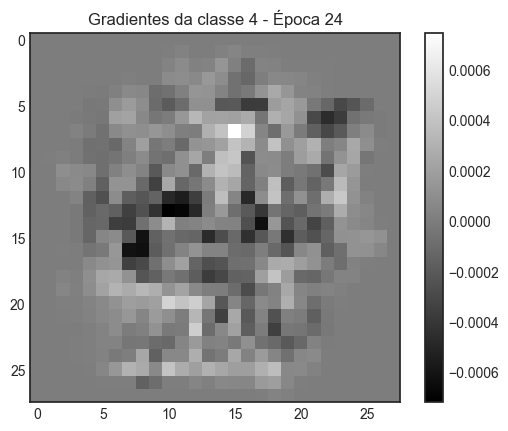

Epoch[25/100], Loss: 0.071532, Acc: 0.998000


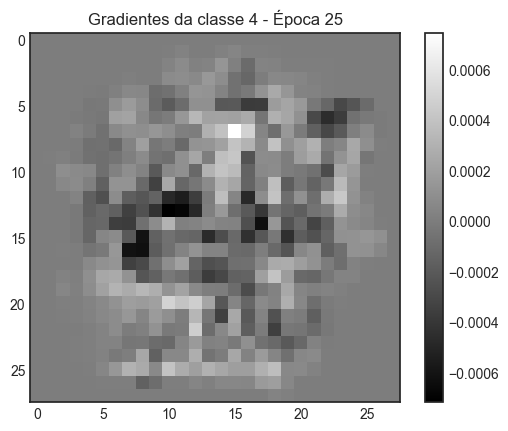

Epoch[26/100], Loss: 0.071425, Acc: 0.998000


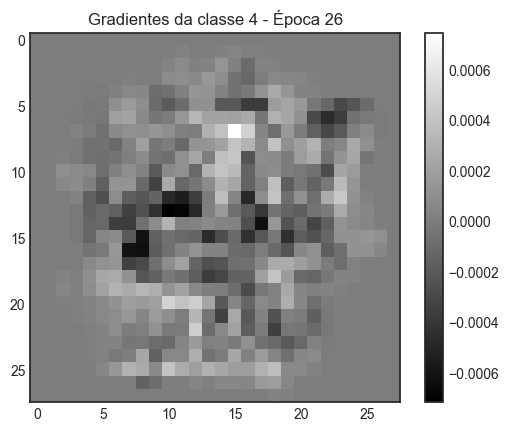

Epoch[27/100], Loss: 0.071318, Acc: 0.998000


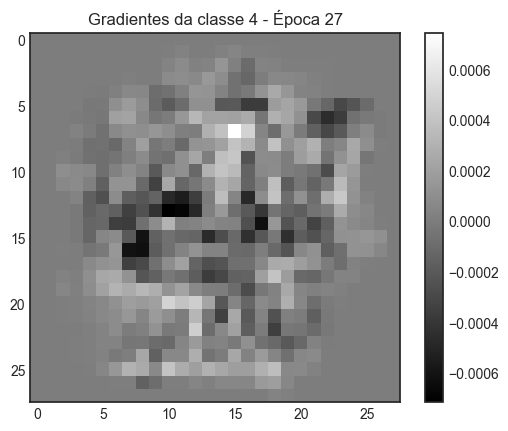

Epoch[28/100], Loss: 0.071211, Acc: 0.998000


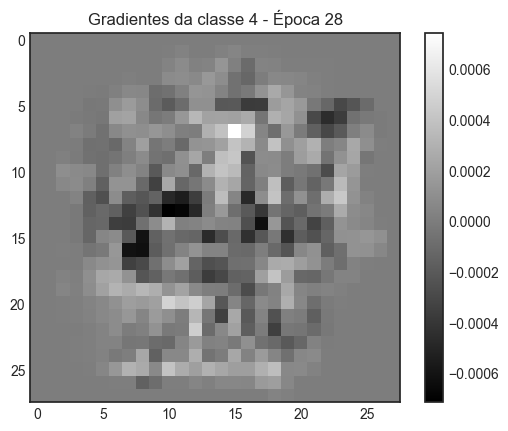

Epoch[29/100], Loss: 0.071104, Acc: 0.998000


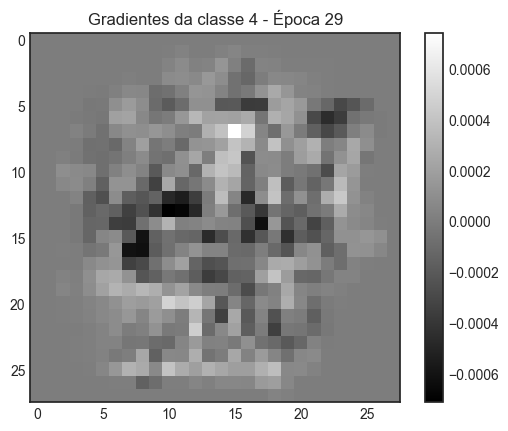

Epoch[30/100], Loss: 0.070998, Acc: 0.998000


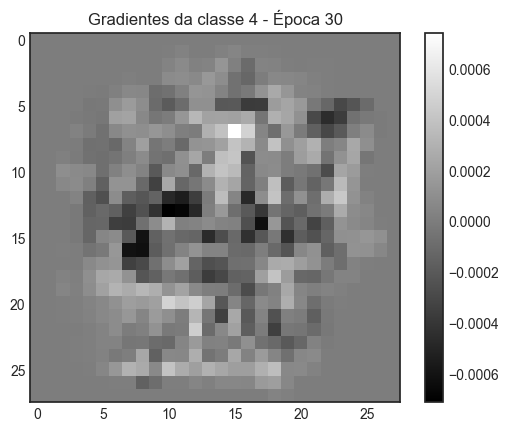

Epoch[31/100], Loss: 0.070892, Acc: 0.998000


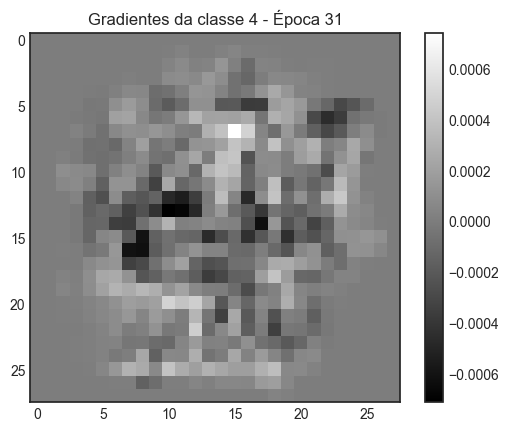

Epoch[32/100], Loss: 0.070787, Acc: 0.998000


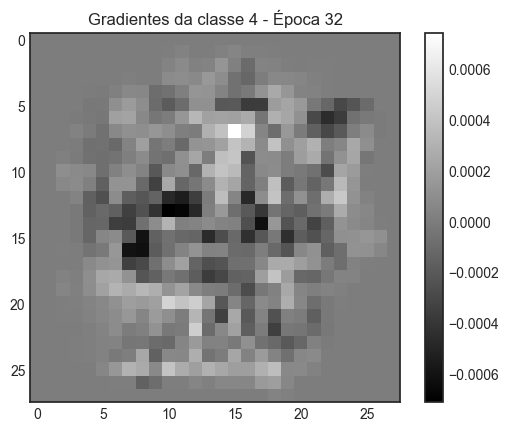

Epoch[33/100], Loss: 0.070681, Acc: 0.998000


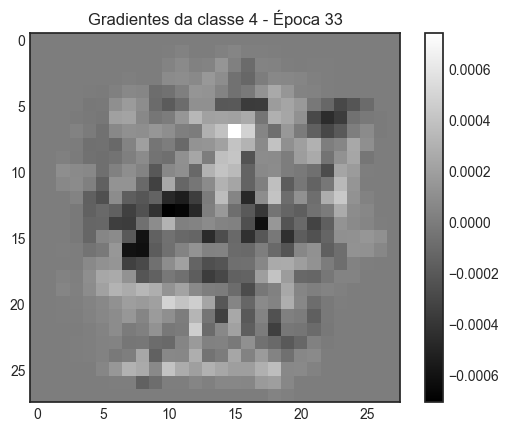

Epoch[34/100], Loss: 0.070576, Acc: 0.998000


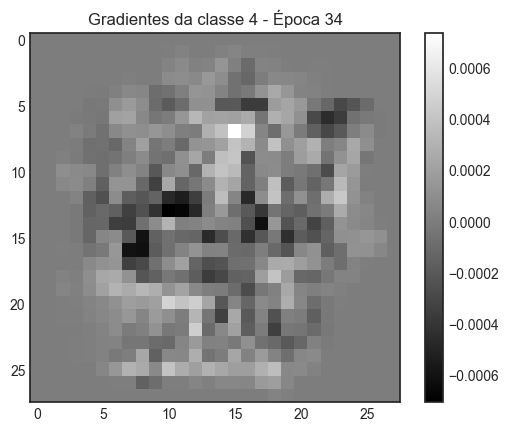

Epoch[35/100], Loss: 0.070472, Acc: 0.998000


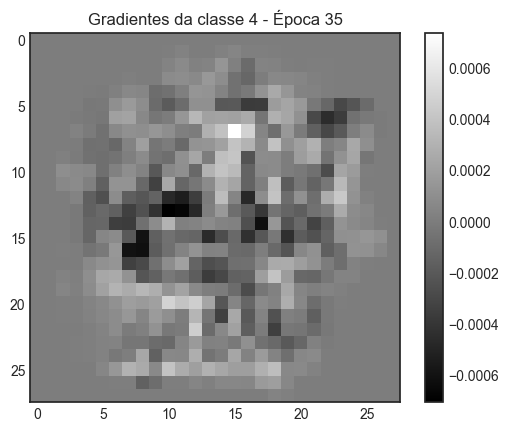

Epoch[36/100], Loss: 0.070367, Acc: 0.998000


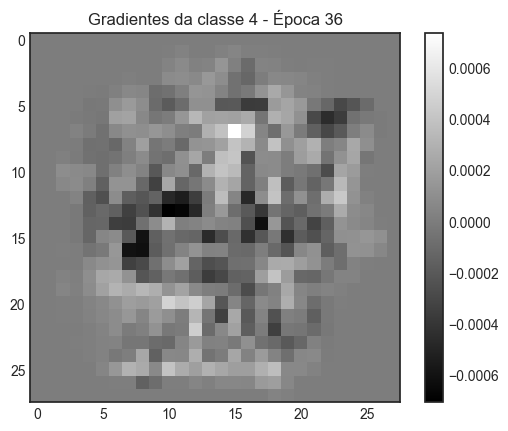

Epoch[37/100], Loss: 0.070263, Acc: 0.998000


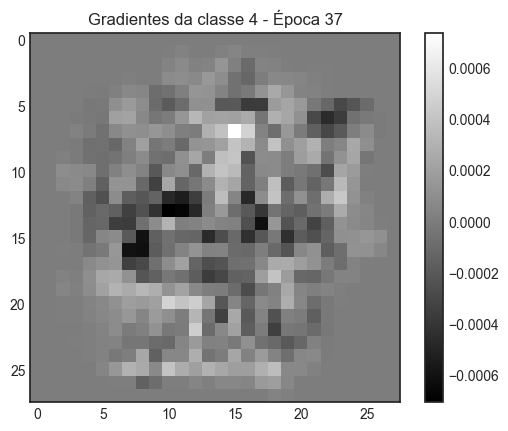

Epoch[38/100], Loss: 0.070159, Acc: 0.998000


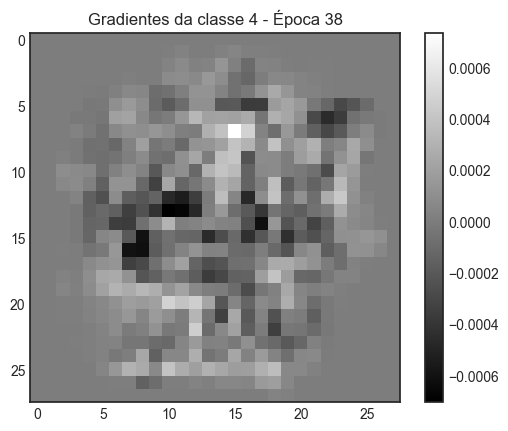

Epoch[39/100], Loss: 0.070056, Acc: 0.998000


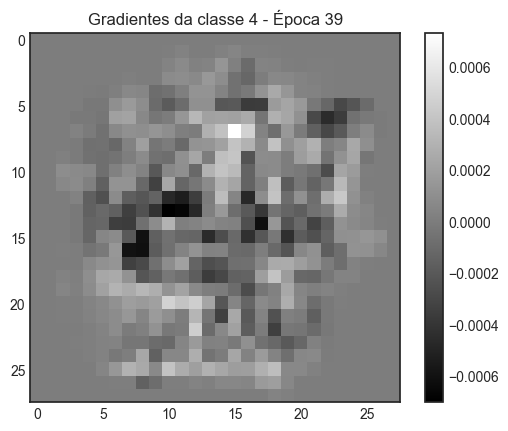

Epoch[40/100], Loss: 0.069952, Acc: 0.998000


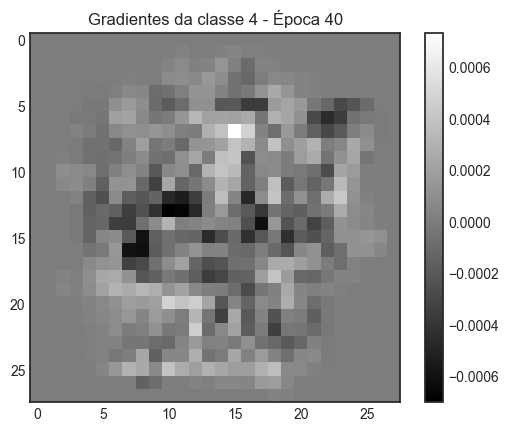

Epoch[41/100], Loss: 0.069849, Acc: 0.998000


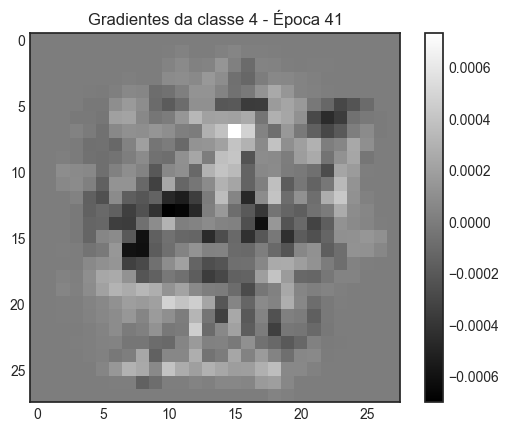

Epoch[42/100], Loss: 0.069747, Acc: 0.998000


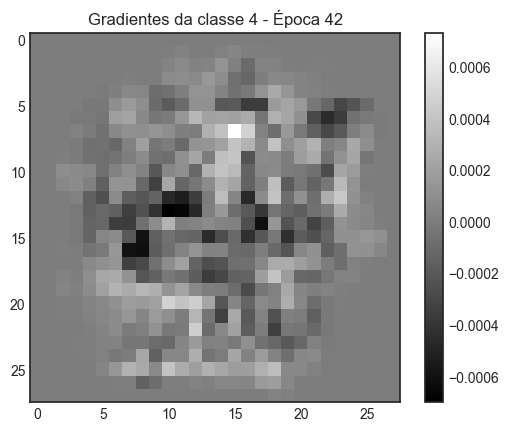

Epoch[43/100], Loss: 0.069644, Acc: 0.998000


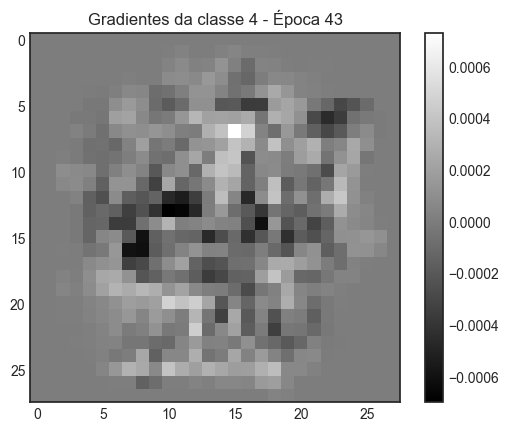

Epoch[44/100], Loss: 0.069542, Acc: 0.998000


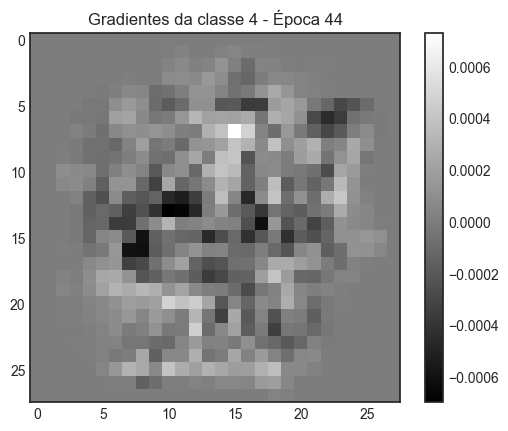

Epoch[45/100], Loss: 0.069440, Acc: 0.998000


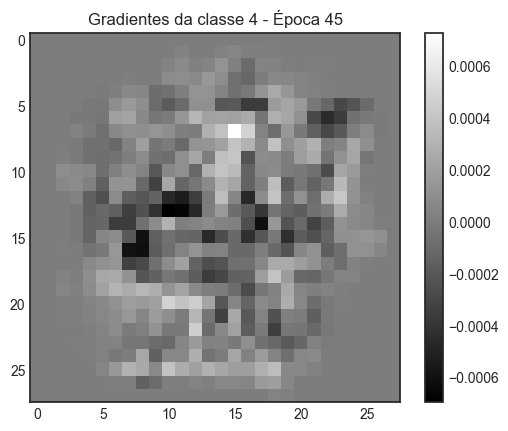

Epoch[46/100], Loss: 0.069339, Acc: 0.998000


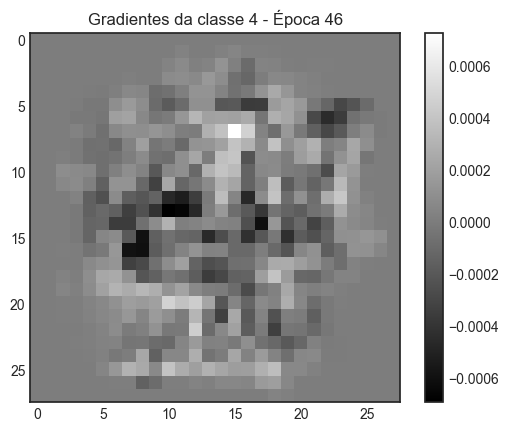

Epoch[47/100], Loss: 0.069238, Acc: 0.998000


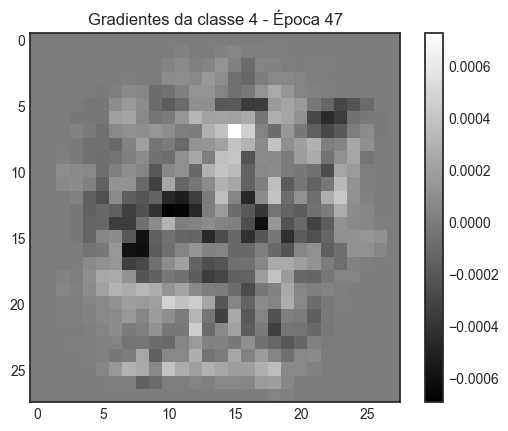

Epoch[48/100], Loss: 0.069137, Acc: 0.998000


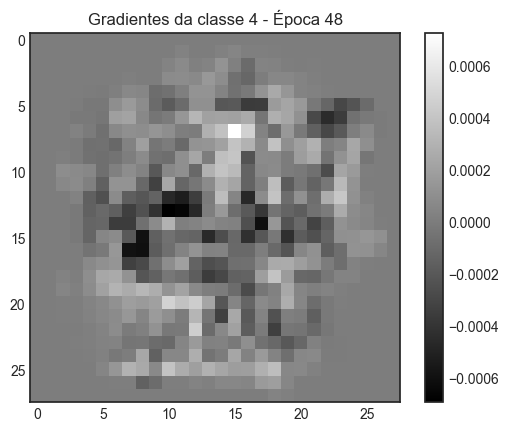

Epoch[49/100], Loss: 0.069036, Acc: 0.998000


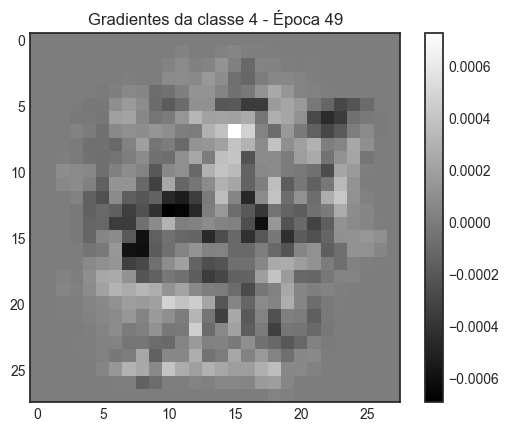

Epoch[50/100], Loss: 0.068936, Acc: 0.998000


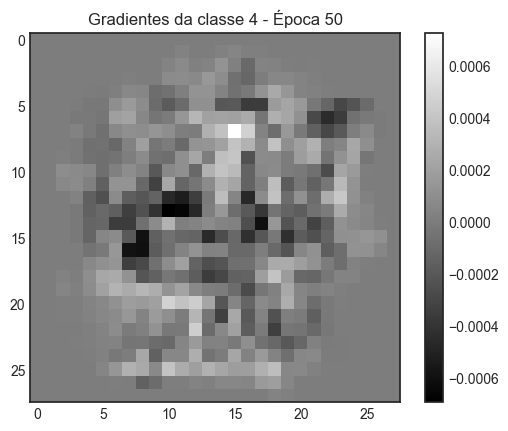

Epoch[51/100], Loss: 0.068835, Acc: 0.998000


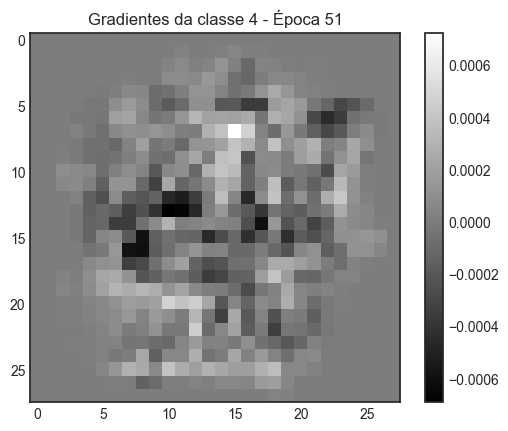

Epoch[52/100], Loss: 0.068736, Acc: 0.998000


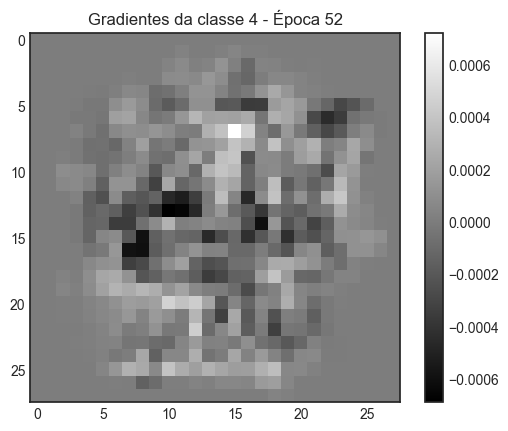

Epoch[53/100], Loss: 0.068636, Acc: 0.998000


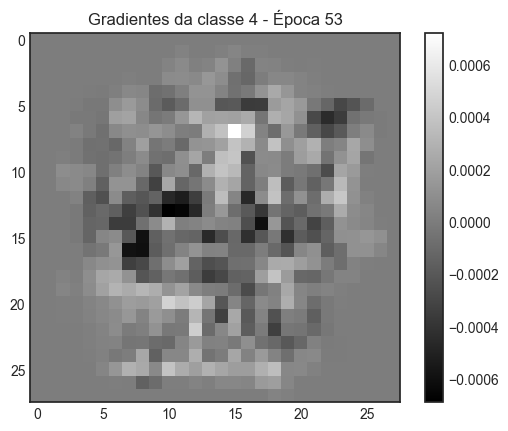

Epoch[54/100], Loss: 0.068537, Acc: 0.998000


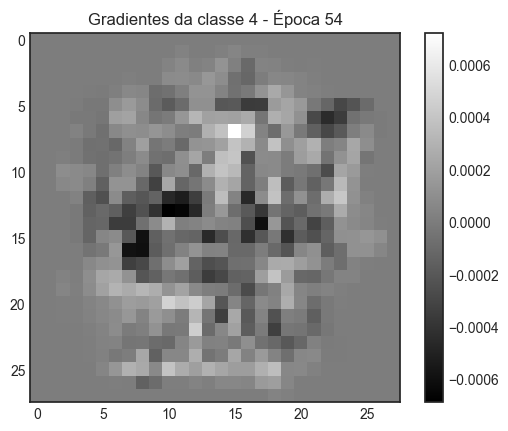

Epoch[55/100], Loss: 0.068438, Acc: 0.998000


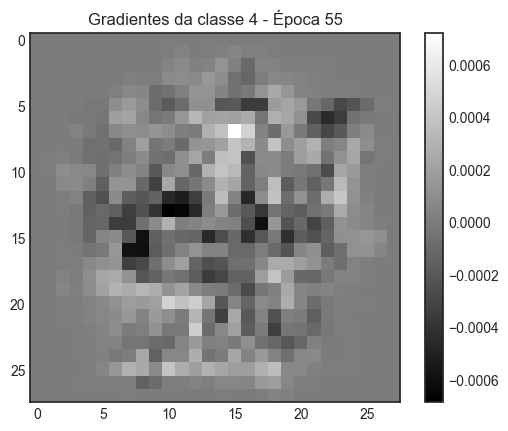

Epoch[56/100], Loss: 0.068339, Acc: 0.998000


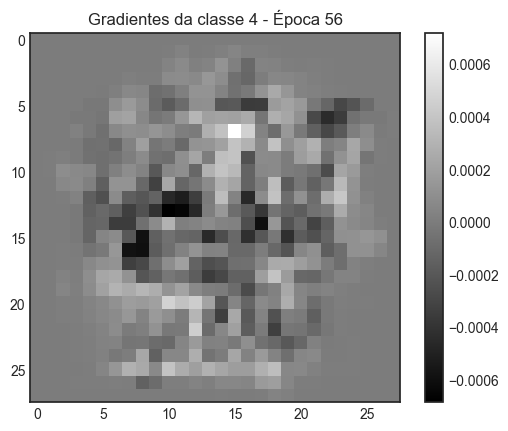

Epoch[57/100], Loss: 0.068240, Acc: 0.998000


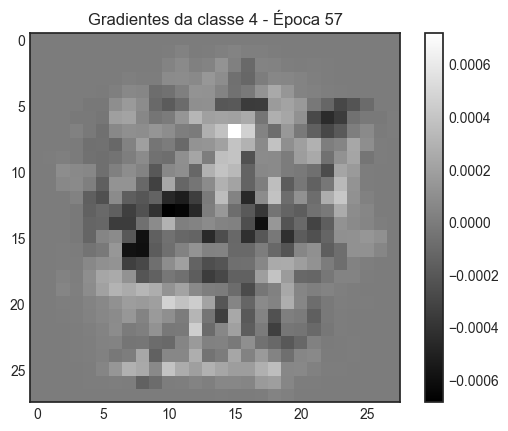

Epoch[58/100], Loss: 0.068142, Acc: 0.998000


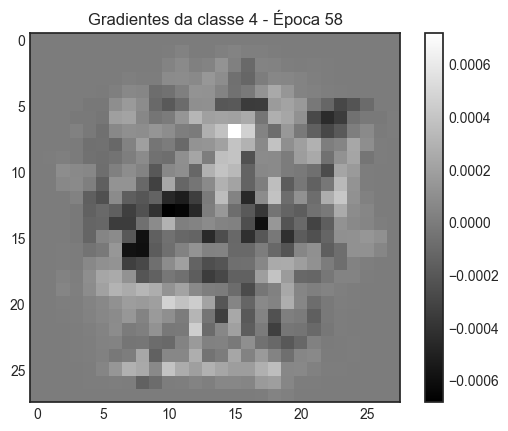

Epoch[59/100], Loss: 0.068044, Acc: 0.998000


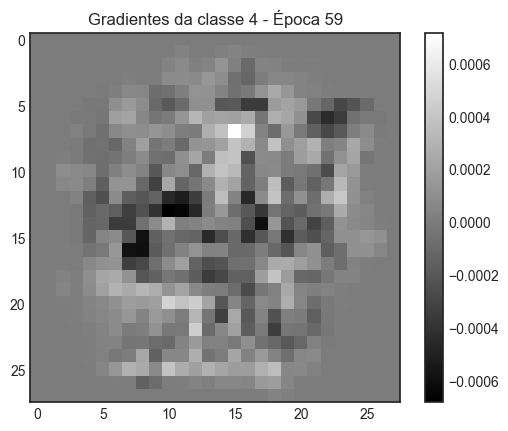

Epoch[60/100], Loss: 0.067947, Acc: 0.998000


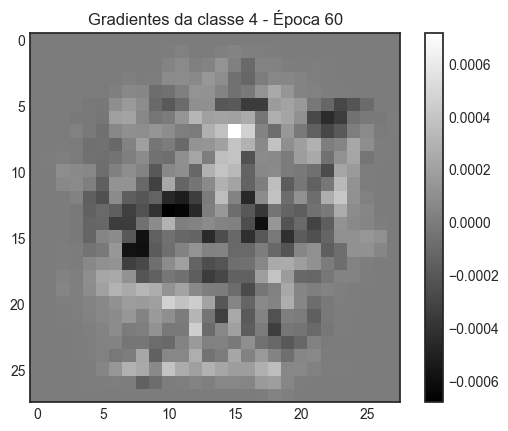

Epoch[61/100], Loss: 0.067849, Acc: 0.998000


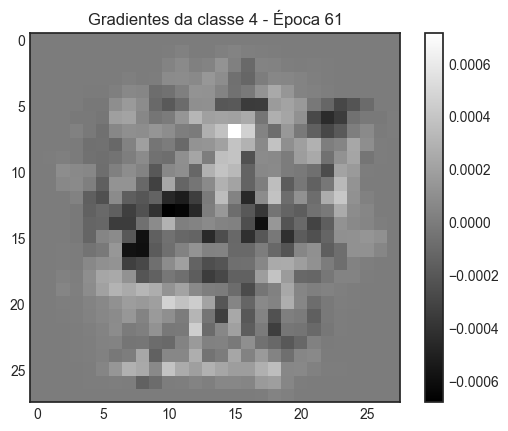

Epoch[62/100], Loss: 0.067752, Acc: 0.998000


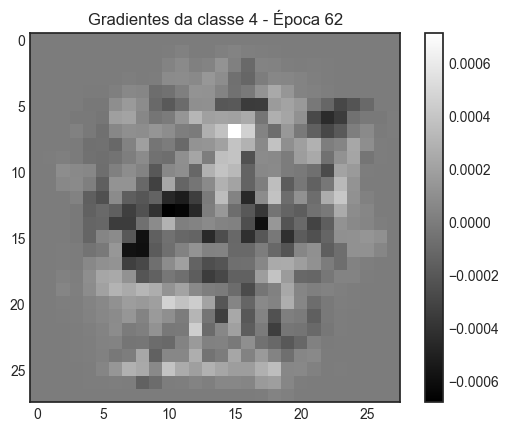

Epoch[63/100], Loss: 0.067655, Acc: 0.998000


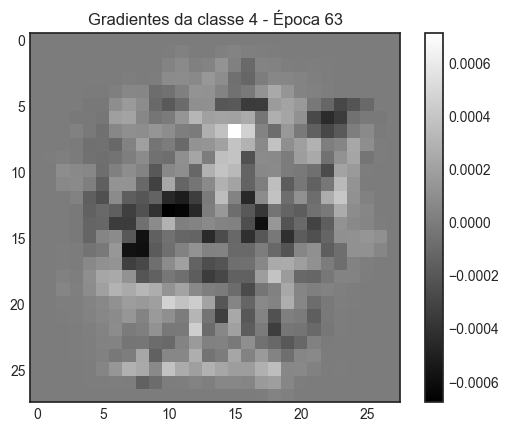

Epoch[64/100], Loss: 0.067558, Acc: 0.998000


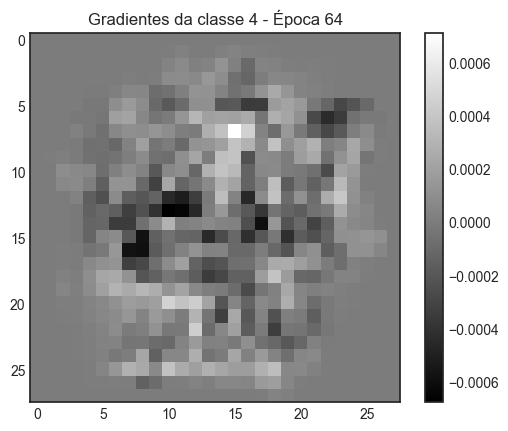

Epoch[65/100], Loss: 0.067462, Acc: 0.998000


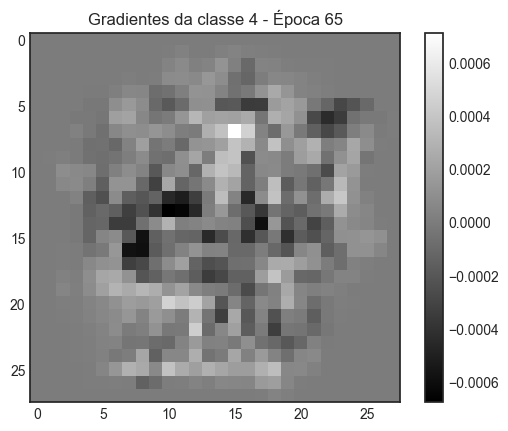

Epoch[66/100], Loss: 0.067366, Acc: 0.998000


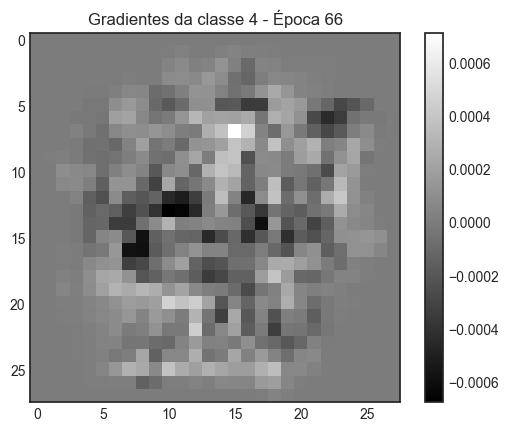

Epoch[67/100], Loss: 0.067270, Acc: 0.998000


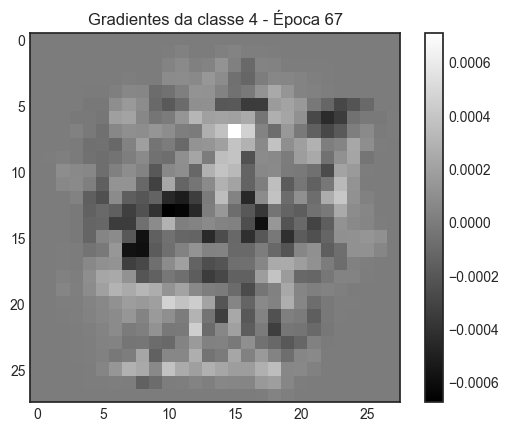

Epoch[68/100], Loss: 0.067175, Acc: 0.998000


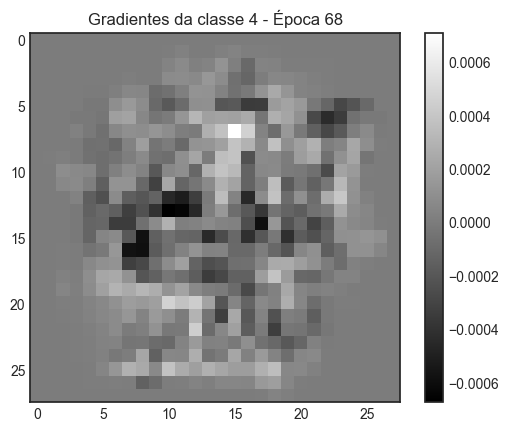

Epoch[69/100], Loss: 0.067079, Acc: 0.998000


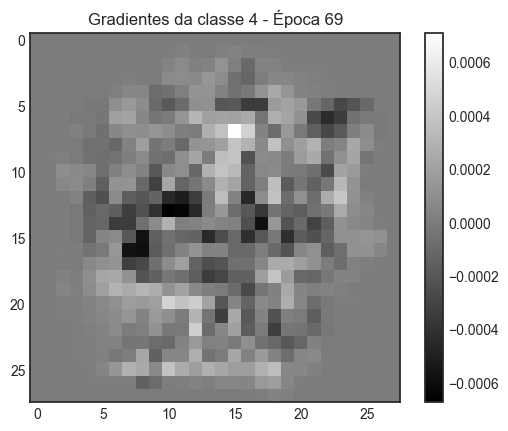

Epoch[70/100], Loss: 0.066984, Acc: 0.998000


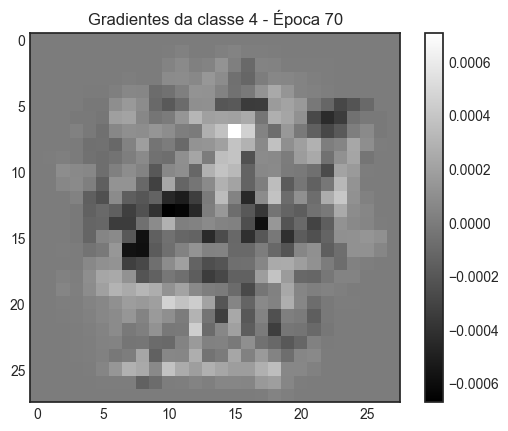

Epoch[71/100], Loss: 0.066889, Acc: 0.998000


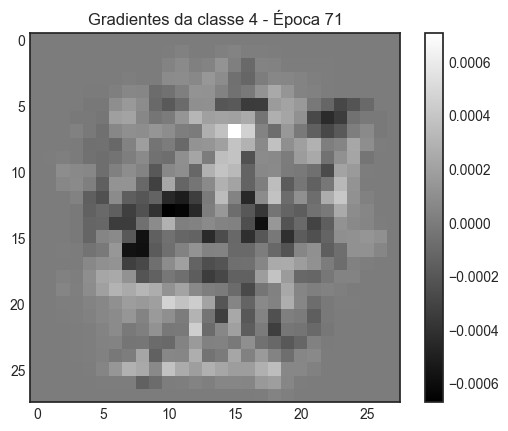

Epoch[72/100], Loss: 0.066795, Acc: 0.998000


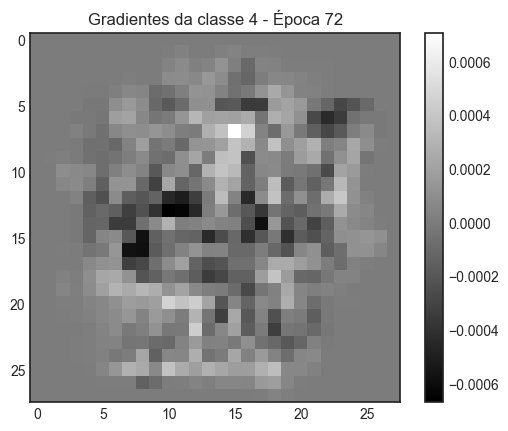

Epoch[73/100], Loss: 0.066701, Acc: 0.998000


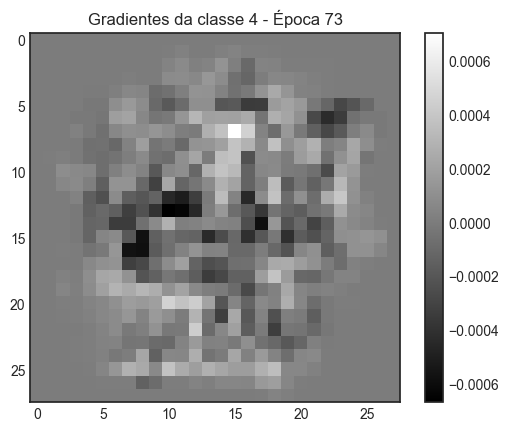

Epoch[74/100], Loss: 0.066606, Acc: 0.998000


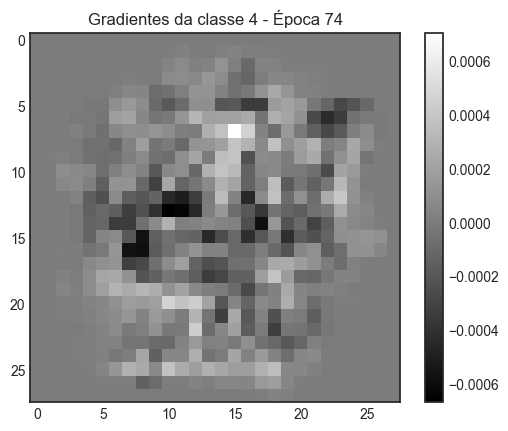

Epoch[75/100], Loss: 0.066513, Acc: 0.998000


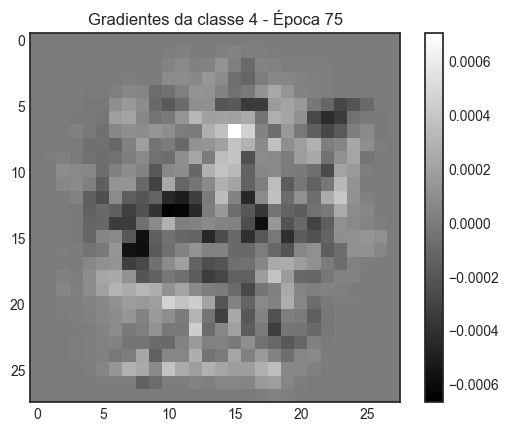

Epoch[76/100], Loss: 0.066419, Acc: 0.998000


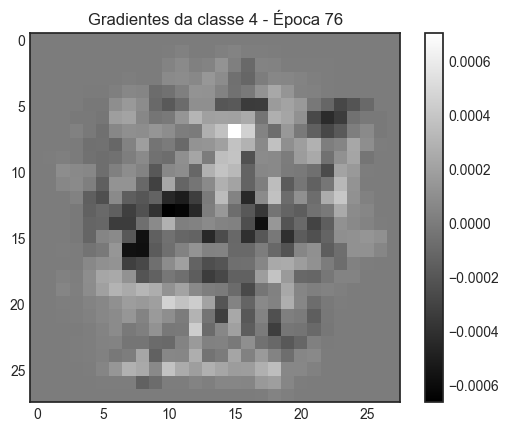

Epoch[77/100], Loss: 0.066326, Acc: 0.998000


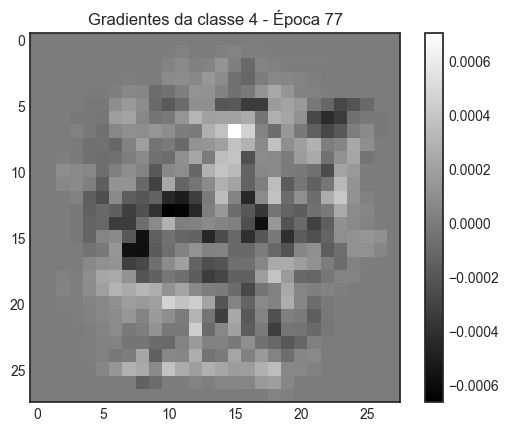

Epoch[78/100], Loss: 0.066233, Acc: 0.998000


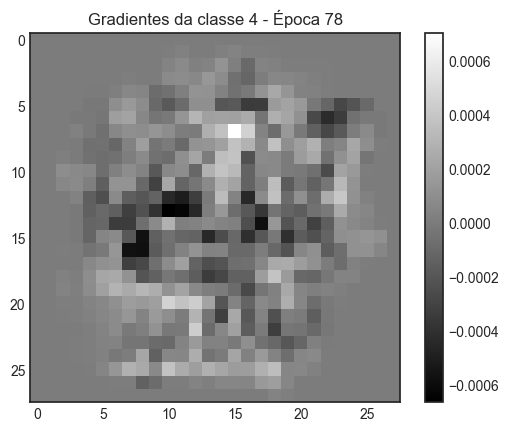

Epoch[79/100], Loss: 0.066140, Acc: 0.998000


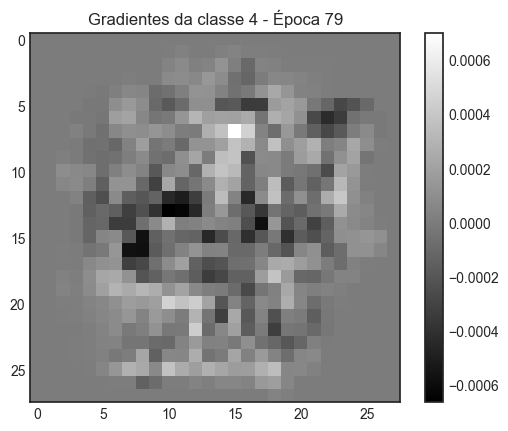

Epoch[80/100], Loss: 0.066047, Acc: 0.998000


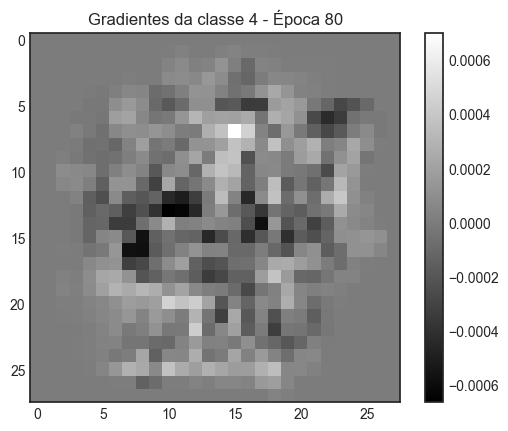

Epoch[81/100], Loss: 0.065955, Acc: 0.998000


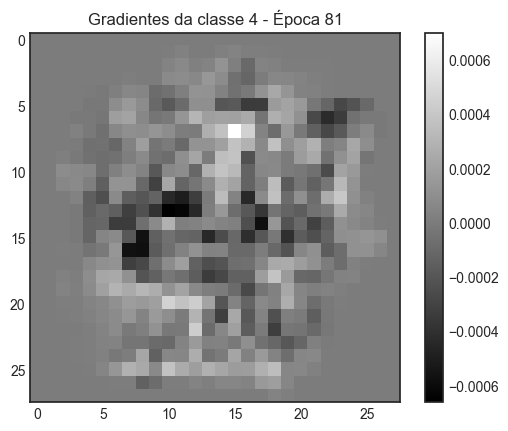

Epoch[82/100], Loss: 0.065863, Acc: 0.998000


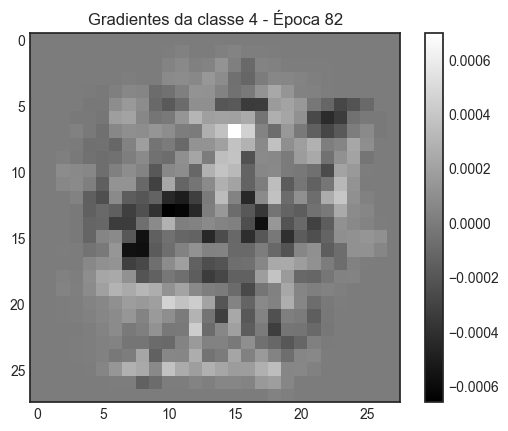

Epoch[83/100], Loss: 0.065771, Acc: 0.998000


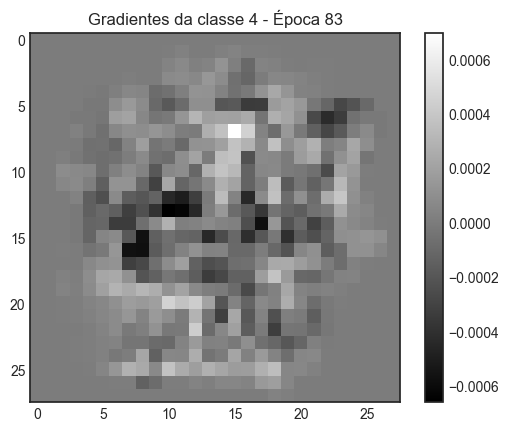

Epoch[84/100], Loss: 0.065680, Acc: 0.998000


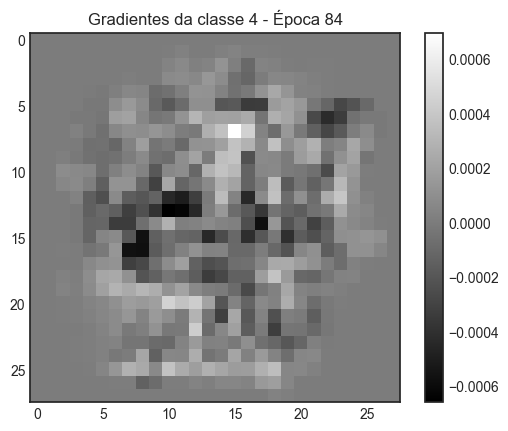

Epoch[85/100], Loss: 0.065588, Acc: 0.998000


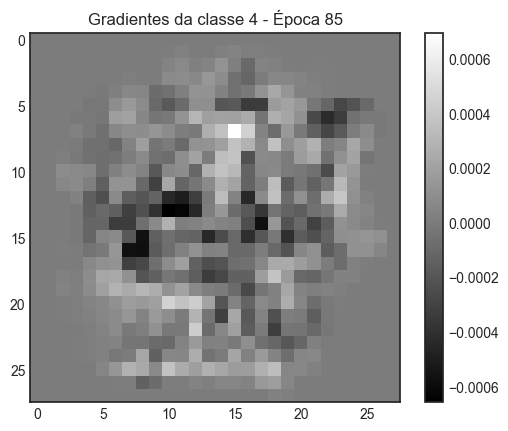

Epoch[86/100], Loss: 0.065497, Acc: 0.998000


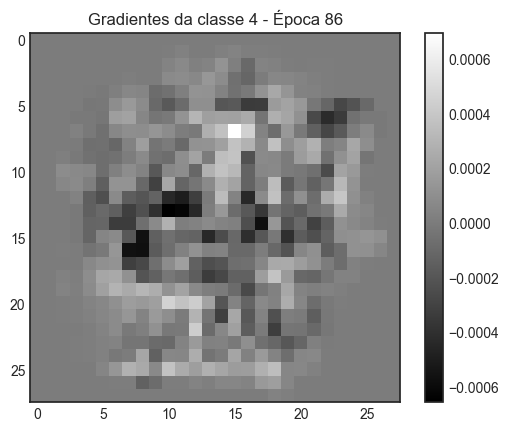

Epoch[87/100], Loss: 0.065406, Acc: 0.998000


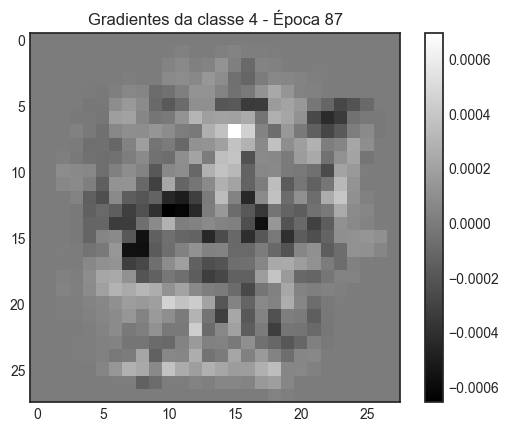

Epoch[88/100], Loss: 0.065316, Acc: 0.998000


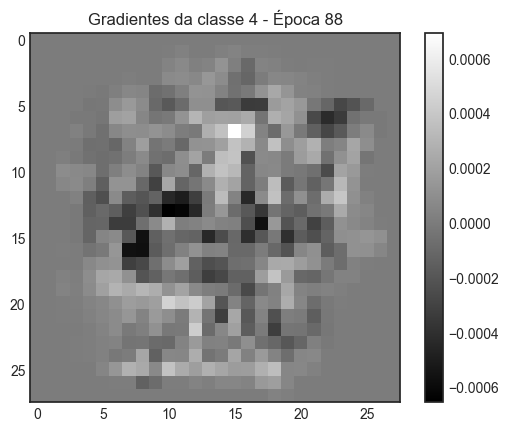

Epoch[89/100], Loss: 0.065226, Acc: 0.999000


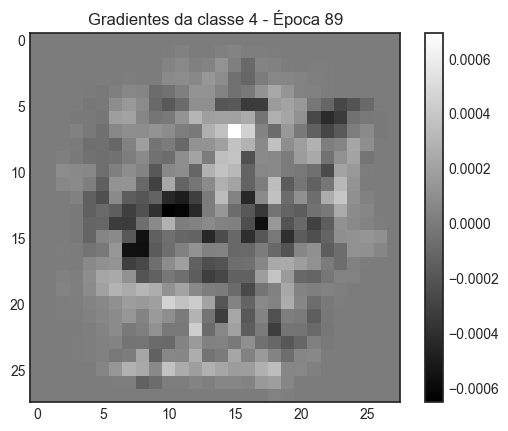

Epoch[90/100], Loss: 0.065135, Acc: 0.999000


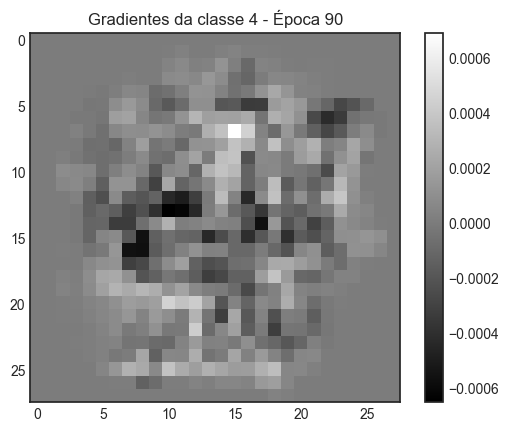

Epoch[91/100], Loss: 0.065046, Acc: 0.999000


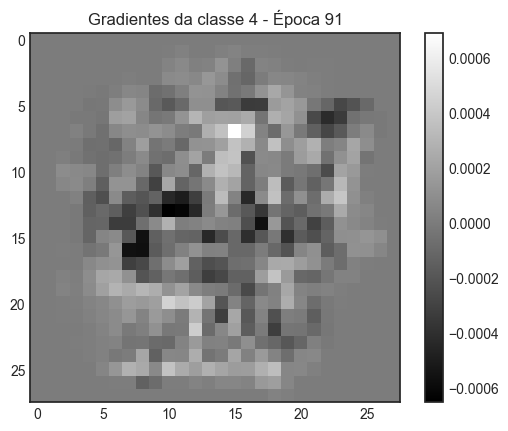

Epoch[92/100], Loss: 0.064956, Acc: 0.999000


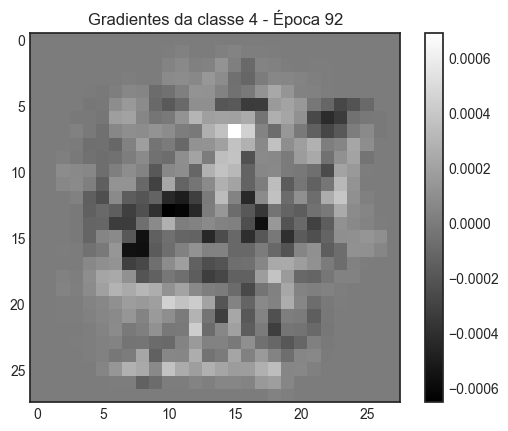

Epoch[93/100], Loss: 0.064866, Acc: 0.999000


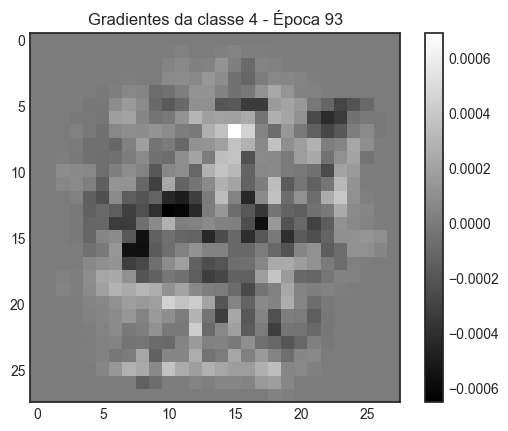

Epoch[94/100], Loss: 0.064777, Acc: 0.999000


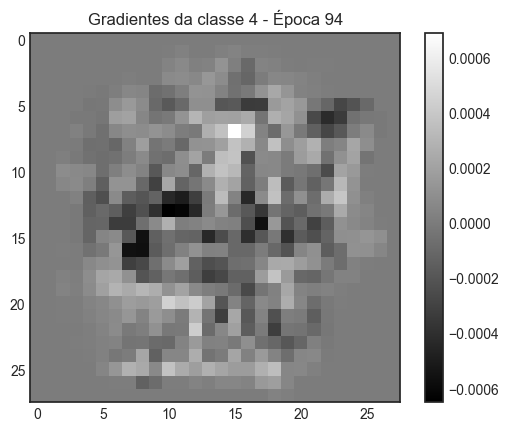

Epoch[95/100], Loss: 0.064688, Acc: 0.999000


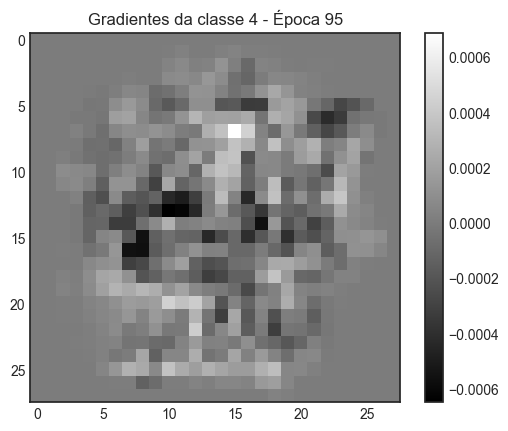

Epoch[96/100], Loss: 0.064600, Acc: 0.999000


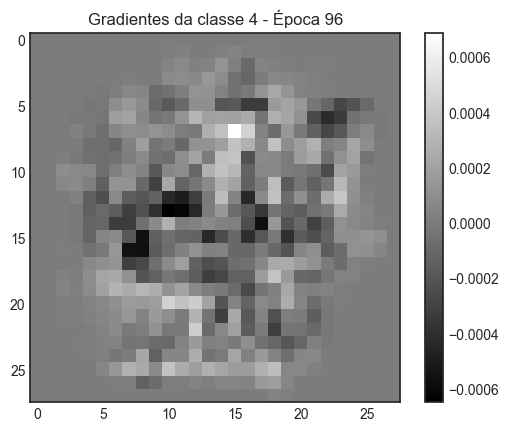

Epoch[97/100], Loss: 0.064511, Acc: 0.999000


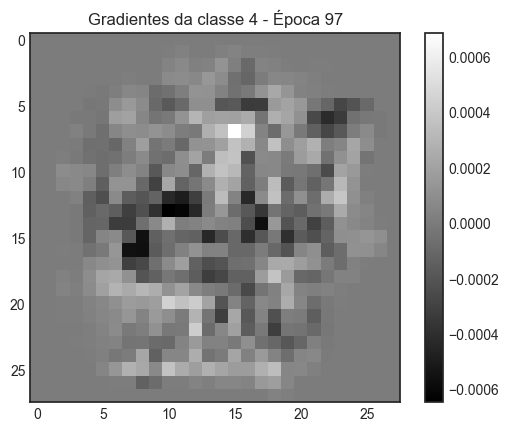

Epoch[98/100], Loss: 0.064423, Acc: 1.000000


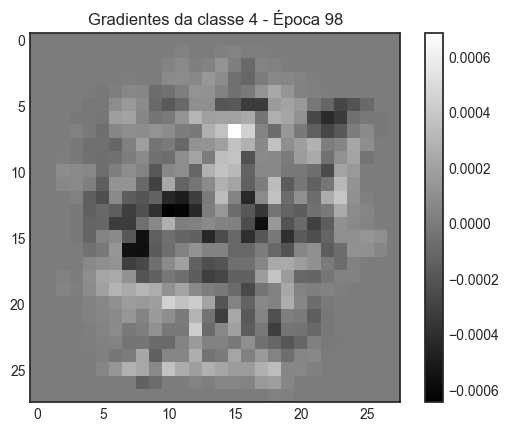

Epoch[99/100], Loss: 0.064335, Acc: 1.000000


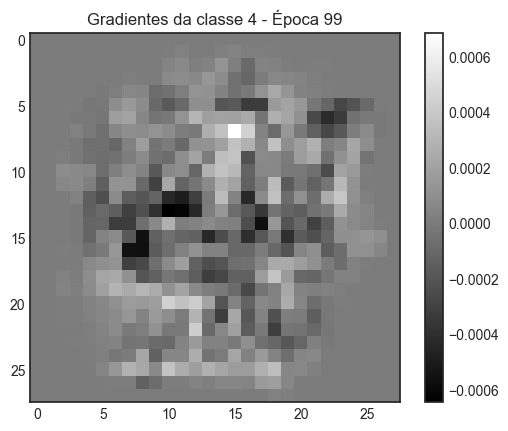

Epoch[100/100], Loss: 0.064247, Acc: 1.000000


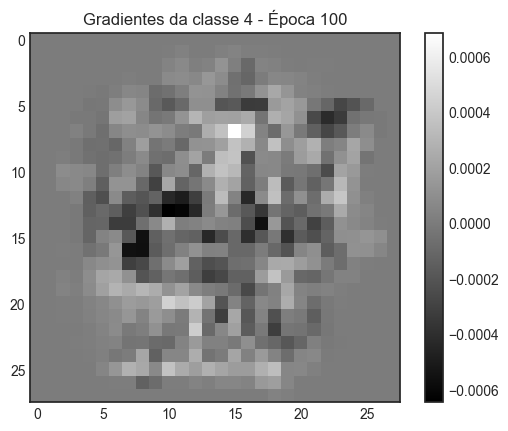

In [41]:
losses = []
zs = []

for i in range(epochs):
    inputs = Variable(x_train.view(-1, 28*28))
    outputs = model(inputs)

    zs.append(outputs[1].detach().numpy())
    loss = criterion(outputs, Variable(y_train))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    print(f"Epoch[{i+1}/{epochs}], Loss: {loss.item():.6f}, Acc: {accuracy:.6f}")

    grad_class_4 = model.weight.grad[4].view(28, 28).detach().numpy()

    plt.title(f"Gradientes da classe 4 - Época {i+1}")
    plt.imshow(grad_class_4, cmap="gray")
    plt.colorbar()
    plt.show()

<details>
<summary>Mostrar Resultado</summary>

```python
losses = []
import numpy

import numpy
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)
    
    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    _, predicts = torch.max(outputs, 1)
    
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    
    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))
    
    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()
```

</details>

## Perguntas

1. Qual é o shape da matriz de entrada na rede?
    > A rede recebe cada imagem "flat", portanto o shape da entrada é: **(batch_size, 28×28) = (batch_size, 784)**

2. Qual é o shape da saída da rede?
    > A saída da rede é um vetor de probabilidades para cada classe, portanto o shape da saída é: **(batch_size, 10)**

3. Qual é o número total de parâmetros da rede, incluindo o bias?
    > O número total de parâmetros é dado por: **(n_entradas × n_classes) + n_classes = (784 × 10) + 10 = 7850**

# Aprendizados
